# Astropy tutorial: putting it all together

In this tutorial we'll go through how to use some of the features of `astropy` as well as the `astroquery` library.

We'll focus on Barnard's Star, which is a nearby star with a very high proper motion.

## Astroquery: Simbad
`astroquery` is a handy python library for accessing information from the online **Simbad** and **Vizier** databases.

Let's first load the **Simbad** interface and send a query for your favorite object.

In [1]:
from astroquery.simbad import Simbad
import astropy.units as u
import numpy as np
from astropy.coordinates import SkyCoord

In [2]:
result = Simbad.query_object("Barnard's Star")
result

<Table masked=True length=1>
      MAIN_ID             RA      ... COO_WAVELENGTH     COO_BIBCODE    
                       "h:m:s"    ...                                   
       object           str13     ...      str1             object      
------------------- ------------- ... -------------- -------------------
NAME Barnard's star 17 57 48.4997 ...              O 2018yCat.1345....0G

In [3]:
type(result)

astropy.table.table.Table

You'll see that this query returns an object with several columns but a single row. This object is in fact an `astropy.table` object.

### Exercise: 

1. Print the columns of the table using the `.columns` and `.colnames` method of `astropy.table`.
2. Use the RA and Dec columns from the table to create a `SkyCoord` object.

In [4]:
result.columns

<TableColumns names=('MAIN_ID','RA','DEC','RA_PREC','DEC_PREC','COO_ERR_MAJA','COO_ERR_MINA','COO_ERR_ANGLE','COO_QUAL','COO_WAVELENGTH','COO_BIBCODE')>

In [5]:
result.colnames

['MAIN_ID',
 'RA',
 'DEC',
 'RA_PREC',
 'DEC_PREC',
 'COO_ERR_MAJA',
 'COO_ERR_MINA',
 'COO_ERR_ANGLE',
 'COO_QUAL',
 'COO_WAVELENGTH',
 'COO_BIBCODE']

In [6]:
result["RA"], result["DEC"]

(<MaskedColumn name='RA' dtype='str13' unit='"h:m:s"' description='Right ascension' length=1>
 17 57 48.4997,
 <MaskedColumn name='DEC' dtype='str13' unit='"d:m:s"' description='Declination' length=1>
 +04 41 36.111)

In [7]:
SkyCoord(ra=result["RA"], dec=result["DEC"], unit=(u.hourangle, u.deg))

<SkyCoord (ICRS): (ra, dec) in deg
    [(269.45208208, 4.69336417)]>

## Dealing with FITS files: headers
Let's download two FITS images from the Very Large Telescope of the European Southern Observatory. These files are on the ASTRON FTP, but should they disappear in the future you can download them from the ESO archive (use http://archive.eso.org/cms/eso-data/eso-data-direct-retrieval.html with identifiers _FORS2.2003-04-11T08:49:16.002_ and _FORS2.2016-05-16T07:29:38.764_).

Again, let's start with importing some required libraries and download the two FITS images from the ASTRON FTP.

To open a FITS file we'll need to import the `fits` module of `astropy.io`. When opening a FITS file, it return a list of _header data units_ (HDUs), where each HDU contains a header and associated data.

In [8]:
from astropy.io import fits

In [9]:
hdu2003 = fits.open("ftp://ftp.astron.nl/outgoing/bassa/FORS2.2003-04-11T08:49:16.002.fits")

In [10]:
len(hdu2003)

1

In [11]:
hdu2003[0].header

 [astropy.io.fits.verify]


SIMPLE  =                    T / Standard FITS format (NOST-100.0)              
BITPIX  =                   16 / # of bits storing pix values                   
NAXIS   =                    2 / # of axes in frame                             
NAXIS1  =                 2048 / # pixels/axis                                  
NAXIS2  =                 1034 / # pixels/axis                                  
ORIGIN  = 'ESO     '           / European Southern Observatory                  
DATE    = '2003-04-11T08:49:20.132' / UT date when this file was written        
MJD-OBS =       52740.36754632 / MJD start (2003-04-11T08:49:16.002)            
DATE-OBS= '2003-04-11T08:49:16.001' / Date of observation                       
EXPTIME =               2.9921 / Total integration time                         
EXTNAME = 'CHIP1   '           / Extension name                                 
CRVAL1  =            269.45200 / value of ref pixel                             
CRPIX1  =               1026

In [11]:
hdu2003[0].data

array([[215, 212, 206, ..., 212, 213, 206],
       [210, 206, 214, ..., 211, 211, 209],
       [211, 212, 212, ..., 206, 212, 209],
       ...,
       [220, 226, 231, ..., 226, 224, 223],
       [ 99,  99, 113, ..., 109, 130, 113],
       [212, 210, 208, ..., 220,  99, 212]], dtype=uint16)

In [12]:
hdu2003[0].data.shape

(1034, 2048)

FITS headers from ESO instruments contain a lot of information, which is useful when analysing the data. 

Here are some example fields in the headers:

In [13]:
print("Telescope position: ",
      hdu2003[0].header["HIERARCH ESO TEL GEOLAT"],
      hdu2003[0].header["HIERARCH ESO TEL GEOLON"],
      hdu2003[0].header["HIERARCH ESO TEL GEOELEV"])

Telescope position:  -24.6253 -70.4022 2648.0


In [14]:
print("Alt/Az at observation start: ",
      hdu2003[0].header["HIERARCH ESO TEL ALT"],
      hdu2003[0].header["HIERARCH ESO TEL AZ"])

Alt/Az at observation start:  59.569 196.74


### Exercise:
1. Use the telescope position to define an `EarthLocation` object. Make sure to load the correct `astropy` module.
2. Use the observation start time to define a `Time` object.
3. Use the RA and DEC keywords to define a `SkyCoord` object.
4. Use all these objects to check if the Alt/Az in the header is correct.

In [15]:
from astropy.coordinates import EarthLocation, AltAz

In [16]:
vlt = EarthLocation(lat=hdu2003[0].header["HIERARCH ESO TEL GEOLAT"]*u.deg, 
                    lon=hdu2003[0].header["HIERARCH ESO TEL GEOLON"]*u.deg,
                    height=hdu2003[0].header["HIERARCH ESO TEL GEOELEV"]*u.m)

In [17]:
pos = SkyCoord(ra=hdu2003[0].header["RA"]*u.deg, dec=hdu2003[0].header["DEC"]*u.deg, frame="fk5")

In [18]:
from astropy.time import Time

In [19]:
tobs = Time(hdu2003[0].header["MJD-OBS"], format="mjd")

In [20]:
aa = pos.transform_to(AltAz(location=vlt, obstime=tobs))

In [21]:
print("Azimuth difference (deg): ", (aa.az + 180.0*u.deg).to(u.deg) - hdu2003[0].header["HIERARCH ESO TEL AZ"]*u.deg)

Azimuth difference (deg):  -0d00m08.7443s


In [22]:
print("Altitude difference (deg): ", aa.alt.to(u.deg) - hdu2003[0].header["HIERARCH ESO TEL ALT"]*u.deg)

Altitude difference (deg):  -0d00m22.2742s


## Dealing with FITS files: data and world coordinate systems
As you could see earlier, the FITS file has a 2D data array of 1034x2048 pixels. Let's play a bit with that.

In [51]:
data2003 = hdu2003[0].data

In [34]:
data2003.shape

(1034, 2048)

In [35]:
type(data2003)

numpy.ndarray

In [36]:
type(data2003[0, 0])

numpy.uint16

In [37]:
hdu2003[0].header["BITPIX"]

16

For manipulating the data further, we convert it to floating point numbers.

In [52]:
data2003 = data2003.astype(float)

Conveniently, the data from a FITS file HDU is provided as `numpy` array of shape 1034 by 2048 pixels. Each pixel is stored as a 16 bit integer, as conveyed by the __BITPIX__ keyword in the FITS header.

Let's plot the image.

In [53]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

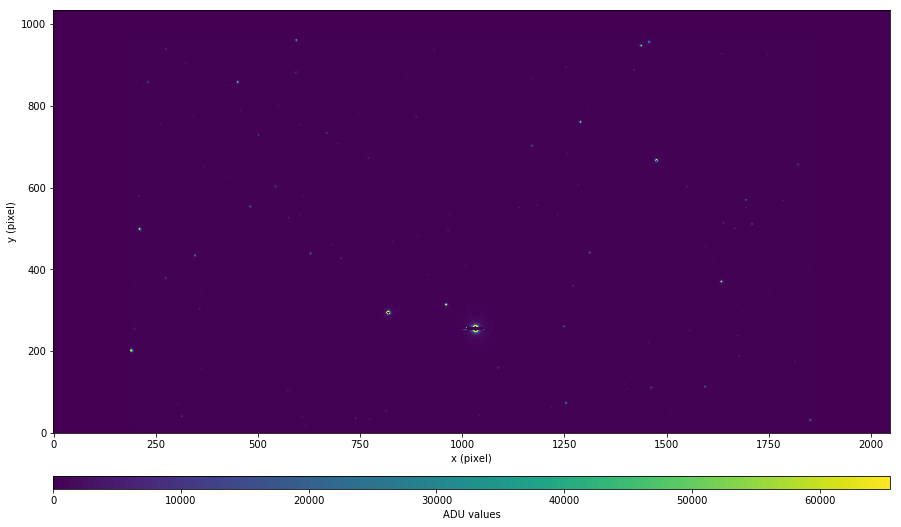

In [54]:
fig, ax = plt.subplots(figsize=(15, 10))
img = ax.imshow(data2003, origin="lower", aspect=1, interpolation=None)
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="3%", pad=0.6)
ax.set_xlabel("x (pixel)")
ax.set_ylabel("y (pixel)")
cbar = fig.colorbar(img, cax=cax, orientation="horizontal");
cbar.set_label("ADU values")

### Exercise:
`imshow` uses the image minimum and maximum to set the dynamic range.
1. Take a cross cut of a single row or column to estimate more sensible values.
2. Create the plot using your estimates (`vmin` and `vmax` keywords of `imshow`)

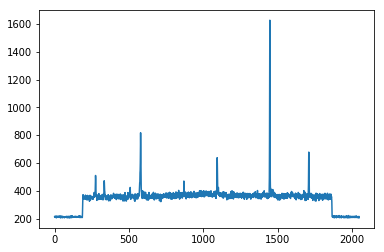

In [55]:
plt.plot(data2003[100, :]);

In [56]:
data2003[data2003<300] = np.nan

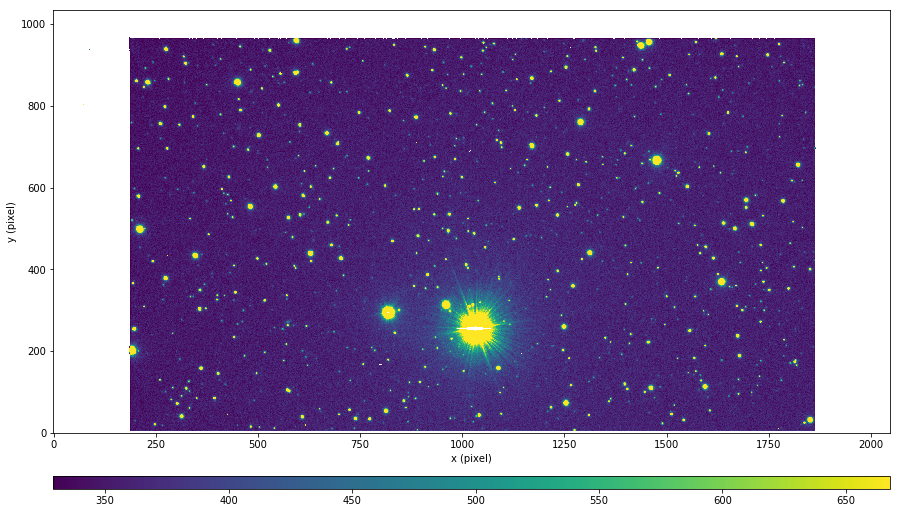

In [57]:
fig, ax = plt.subplots(figsize=(15, 10))
img = ax.imshow(data2003, origin="lower", aspect=1, interpolation=None, 
                vmin=np.nanpercentile(data2003, 1), 
                vmax=np.nanpercentile(data2003, 99))
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="3%", pad=0.6)
ax.set_xlabel("x (pixel)")
ax.set_ylabel("y (pixel)")
fig.colorbar(img, cax=cax, orientation="horizontal");
cbar.set_label("ADU values")

The FITS image contains a _World Coordinate System_ (WCS) which relates pixel positions to celestial coordinates and vice versa.

The following commands load the WCS.

In [58]:
from astropy.wcs import WCS

In [59]:
import warnings

In [60]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    wcs2003 = WCS(hdu2003[0].header)

In [61]:
wcs2003

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 269.452  4.69339  
CRPIX : 1026.5  120.8  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -7.0017e-05  7.0017e-05  
NAXIS : 2048  1034

We can now use the WCS to plot WCS axes on the plot.

In [62]:
import matplotlib.axes as maxes

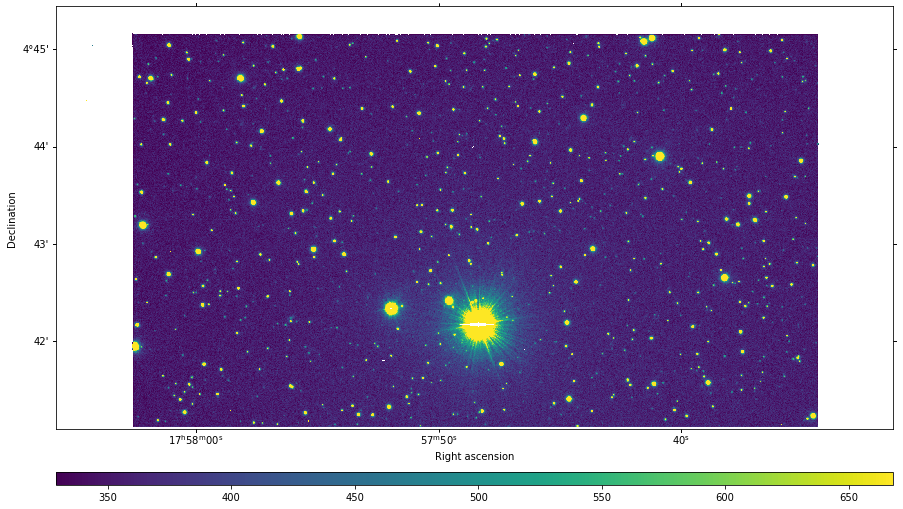

In [63]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection=wcs2003)
img = ax.imshow(data2003, origin="lower", aspect=1, interpolation=None, 
                vmin=np.nanpercentile(data2003, 1), 
                vmax=np.nanpercentile(data2003, 99))
ax.set_xlabel("Right ascension")
ax.set_ylabel("Declination")

divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="3%", pad=0.6, axes_class=maxes.Axes)
fig.colorbar(img, cax=cax, orientation="horizontal");
cbar.set_label("ADU values")

## Make image function

Since we'll make a lot of these images, let's make a function for it, so that we don't have to copy-paste any improvements.

In [154]:
def make_image(data, wcs, year_title, vmin=None, vmax=None, add_colorbar=True):
    """Make an image (imshow) of 2d array data with wcs, add colorbar
    """
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(111, projection=wcs)
    if not vmin:
        vmin=np.nanpercentile(data, 1)
    if not vmax:
        vmax=np.nanpercentile(data, 99)
    cmap = plt.cm.viridis
    cmap.set_bad(cmap(0.05))
    img = ax.imshow(data, origin="lower", aspect=1, interpolation=None, 
                    vmin=vmin,
                    vmax=vmax, cmap=cmap)
    ax.set_xlabel("Right ascension")
    ax.set_ylabel("Declination")
    ax.set_xlim(0, data.shape[1])
    ax.set_ylim(0, data.shape[0])
    ax.grid(color="white")

    title = "Barnard's star in {}\n".format(year_title)
    if year_title in (2003, 2016):
        title += "Source: ESO / FORS"
    else:
        title += "GAIA DR2, space motion propagated using astropy"
    ax.set_title(title)

    if add_colorbar:
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("bottom", size="3%", pad=0.6, axes_class=maxes.Axes)
        fig.colorbar(img, cax=cax, orientation="horizontal");
        cbar.set_label("ADU values")
    return ax

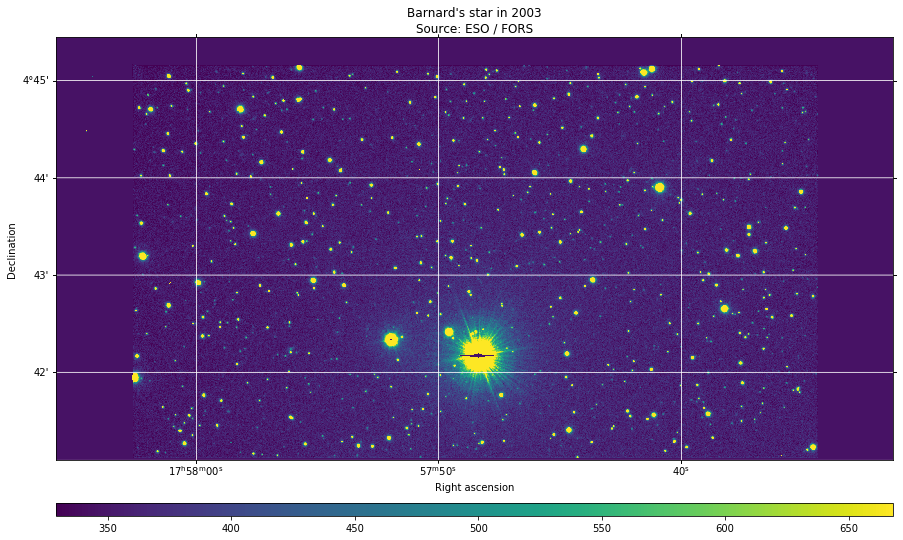

In [92]:
ax = make_image(data2003, wcs2003, 2003);

## Astroquery: Vizier
Let's import the `Vizier` module from `astroquery`.

In [66]:
from astroquery.vizier import Vizier

### Exercise: 
1. Use the `find_catalogs` method from `Vizier` to search for the GAIA DR2 catalog.
2. Use the Vizier.query_region method to query the GAIA DR2 catalog (I/345) for objects within 0.1 degrees around Barnard's Star.

In [67]:
print(Vizier.find_catalogs("GAIA DR2"))

OrderedDict([('I/345', </>), ('I/347', </>), ('I/348', </>), ('IV/35', </>), ('IV/36', </>), ('J/A+A/616/A12', </>), ('J/A+A/616/A37', </>), ('J/A+A/616/L2', </>), ('J/A+A/616/L15', </>), ('J/A+A/617/A135', </>), ('J/A+A/618/A44', </>), ('J/A+A/618/A56', </>), ('J/A+A/618/A93', </>), ('J/A+A/619/A8', </>), ('J/A+A/619/A106', </>), ('J/A+A/619/A155', </>), ('J/A+A/619/A180', </>), ('J/A+A/619/L8', </>), ('J/A+A/620/A91', </>), ('J/A+A/620/A128', </>), ('J/A+A/620/A141', </>), ('J/A+A/620/A155', </>), ('J/A+A/620/A172', </>), ('J/A+A/621/A38', </>), ('J/A+A/621/A48', </>), ('J/A+A/621/L2', </>), ('J/A+A/621/L3', </>), ('J/A+A/622/A60', </>), ('J/A+A/622/A165', </>), ('J/A+A/622/L13', </>), ('J/A+A/623/A22', </>), ('J/A+A/623/A25', </>), ('J/A+A/623/A72', </>), ('J/AJ/156/94', </>), ('J/MNRAS/482/4570', </>), ('J/MNRAS/482/5138', </>), ('J/MNRAS/484/2832', </>)])


In [68]:
gaiaresult = Vizier.query_region("Barnard's Star", radius=0.1*u.deg, catalog="I/345")
gaiaresult

TableList with 2 tables:
	'0:I/345/gaia2' with 32 column(s) and 50 row(s) 
	'1:I/345/rvstdcat' with 32 column(s) and 1 row(s) 

You will see that this query returned two results, the gaia2 catalog, as well as the catalog with radial velocity standards. At this point we are only interested in the first catalog. Unfortunately, the first catalog only has 50 rows, because this is the `Vizier` standard. To remove this limit, set `Vizier.ROW_LIMIT = -1`. Be aware that this may mean you will be downloading a large amount of data. Rerun the query with the new limit.

In [69]:
Vizier.ROW_LIMIT = -1
gaiaresult = Vizier.query_region("Barnard's Star", radius=0.1*u.deg, catalog="I/345/gaia2")
gaiaresult

TableList with 1 tables:
	'0:I/345/gaia2' with 32 column(s) and 2336 row(s) 

This result contains the following columns:

In [70]:
gaiadata = gaiaresult[0]
gaiadata.columns

<TableColumns names=('RA_ICRS','e_RA_ICRS','DE_ICRS','e_DE_ICRS','Source','Plx','e_Plx','pmRA','e_pmRA','pmDE','e_pmDE','Dup','FG','e_FG','Gmag','e_Gmag','FBP','e_FBP','BPmag','e_BPmag','FRP','e_FRP','RPmag','e_RPmag','BP-RP','RV','e_RV','Teff','AG','E_BP-RP_','Rad','Lum')>

A cool feature of this table is that it contains information about the unit of each column.

In [71]:
print(gaiadata["RA_ICRS"].unit)
print(gaiadata["pmRA"].unit)

deg
mas / yr


### Exercise: 
1. Use the RA and DEC columns to define `SkyCoord` objects for the entire table, now using the table units.
2. Use these coordinates to overplot the GAIA stars on the FITS image. Use the sizes of the markers to denote the brightness of these stars. Tips: use the size in `plt.scatter` to change the marker sizes, use the `Gmag` column for magnitudes and convert them to size $r$ using $r=r_\mathrm{max}+(r_\mathrm{min}-r_\mathrm{max})(M-M_\mathrm{min})/(M_\mathrm{max}-M_\mathrm{min})$. Good values for this exercise are $M_\mathrm{min}=5$, $M_\mathrm{max}=20$, $r_\mathrm{min}=1$ and $r_\mathrm{max}=200$. Use the `transform=ax.get_transform("world")` keyword to force plotting in world coordinate systems.
3. Make the same figure for the second FITS file. Can you identify Barnard's Star?

In [72]:
columns = gaiadata["RA_ICRS"], gaiadata["DE_ICRS"]
p = SkyCoord(ra=columns[0], dec=columns[1], frame="icrs", unit=(columns[0].unit, columns[1].unit))

In [73]:
mag = gaiadata["Gmag"]
minmag, maxmag = 5, 20
minrad, maxrad = 1, 200
rad = np.interp(mag, [minmag, maxmag], [maxrad, minrad])

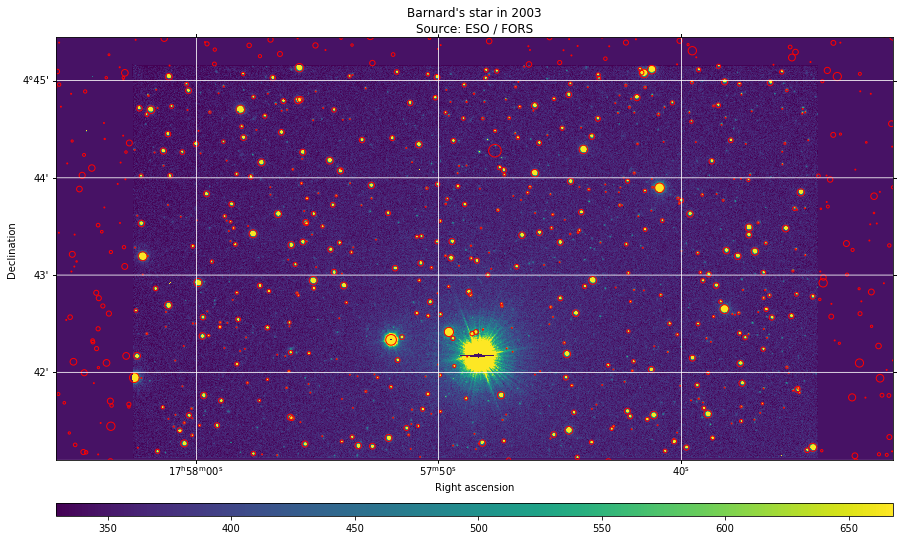

In [93]:
ax = make_image(data2003, wcs2003, 2003)
ax.scatter(p.ra, p.dec, s=rad, transform=ax.get_transform("world"), marker="o", color="r", facecolors="None");

In [77]:
hdu2016 = fits.open("ftp://ftp.astron.nl/outgoing/bassa/FORS2.2016-05-16T07:29:38.764.fits")

In [78]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    wcs2016 = WCS(hdu2016[0].header)

In [94]:
data2016 = hdu2016[0].data.astype(float)

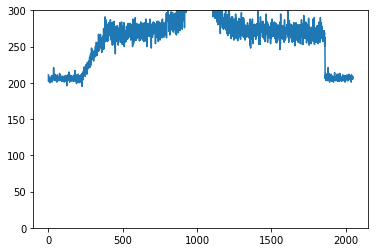

In [95]:
fig, ax = plt.subplots()
ax.plot(data2016[100,:]);
ax.set_ylim([0,300]);

In [96]:
data2016[data2016 < 220] = np.nan

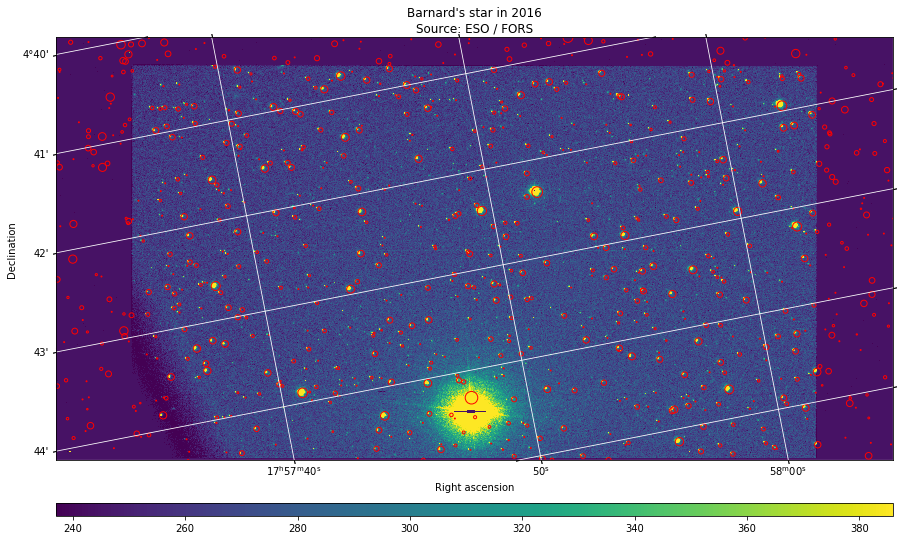

In [97]:
ax = make_image(data2016, wcs2016, 2016)
ax.scatter(p.ra, p.dec, s=rad, transform=ax.get_transform("world"), marker="o", color="r", facecolors="None");

## Parallax and distances
The GAIA catalog has a parallax column, `Plx`. 

In [122]:
gaiadata["Plx"]

<MaskedColumn name='Plx' dtype='float64' unit='mas' format='{:10.4f}' description='? Absolute stellar parallax (parallax)' length=2336>
    1.5473
   -0.3391
   -0.9632
    0.5543
    0.4149
   -1.7725
    0.4952
    0.4355
    0.2315
    0.5453
    0.4441
   -0.6551
       ...
    0.6625
    0.0012
    0.0556
    0.3968
    0.3572
   -0.1636
   -0.2324
    0.3984
    0.7629
    0.4629
    0.5527
    1.2804

This column is a `MaskedColumn` in `astropy.Table`, which allows data entries to be missing. See http://docs.astropy.org/en/stable/table/masking.html. You'll also see that some parallax values are negative, which is physically impossible, but an artifact of the GAIA processing of low signal-to-noise objects. 

To convert a `MaskedColumn` to a regular `Column`, we can fill in the values which are missing, like so:

In [98]:
gaiadata["Plx"].fill_value = 1e-2 # Some small value
plx = gaiadata["Plx"].filled()
plx

<Column name='Plx' dtype='float64' unit='mas' format='{:10.4f}' description='? Absolute stellar parallax (parallax)' length=2336>
    1.5473
   -0.3391
   -0.9632
    0.5543
    0.4149
   -1.7725
    0.4952
    0.4355
    0.2315
    0.5453
    0.4441
   -0.6551
       ...
    0.6625
    0.0012
    0.0556
    0.3968
    0.3572
   -0.1636
   -0.2324
    0.3984
    0.7629
    0.4629
    0.5527
    1.2804

In [99]:
from astropy.coordinates import Distance

In [63]:
Distance?

Init signature:
Distance(
    value=None,
    unit=None,
    z=None,
    cosmology=None,
    distmod=None,
    parallax=None,
    dtype=None,
    copy=True,
    order=None,
    subok=False,
    ndmin=0,
    allow_negative=False,
)
Docstring:     
A one-dimensional distance.

This can be initialized in one of four ways:

* A distance ``value`` (array or float) and a ``unit``
* A `~astropy.units.Quantity` object
* A redshift and (optionally) a cosmology.
* Providing a distance modulus

Parameters
----------
value : scalar or `~astropy.units.Quantity`.
    The value of this distance.
unit : `~astropy.units.UnitBase`
    The units for this distance, *if* ``value`` is not a
    `~astropy.units.Quantity`. Must have dimensions of distance.
z : float
    A redshift for this distance.  It will be converted to a distance
    by computing the luminosity distance for this redshift given the
    cosmology specified by ``cosmology``. Must be given as a keyword
    argument.
cosmology : ``Cosmology``

The `Distance` class of `astropy.coordinates` is a useful way of converting these parallaxes into distances.

### Exercise: 
1. Use the `Distance` class to convert the GAIA parallax values to distances. Note that `Distance` can not take an `astropy.Column` object, so you can change it to a `Quantity` using `plx.to(plx.unit)`.

In [100]:
print(type(plx))
print(type(plx.to(plx.unit)))

<class 'astropy.table.column.Column'>
<class 'astropy.units.quantity.Quantity'>


In [102]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    distances = Distance(parallax=plx.to(plx.unit), allow_negative=True)

## Space motion
Since version 3 of `astropy` it is possible to propagate objects based on their position, distance, proper motion and radial velocity. The GAIA DR2 provides most of this information. The following exercises will show how to do this.

First, let's load the required modules

In [105]:
import numpy as np
from astropy.time import Time

Let's set the epoch of the GAIA DR2 positions.

In [106]:
epoch = Time(2015.5, format="decimalyear")

In [107]:
epoch.isot

'2015-07-02T11:59:59.500'

In [108]:
gaiadata[0]

<Row index=0 masked=True>
    RA_ICRS     e_RA_ICRS     DE_ICRS     e_DE_ICRS        Source          Plx      e_Plx     pmRA    e_pmRA     pmDE    e_pmDE   Dup       FG         e_FG      Gmag   e_Gmag     FBP        e_FBP     BPmag  e_BPmag     FRP        e_FRP     RPmag  e_RPmag  BP-RP     RV     e_RV    Teff     AG   E_BP-RP_   Rad     Lum  
      deg          mas          deg          mas                           mas       mas    mas / yr mas / yr  mas / yr mas / yr           e-/s        e-/s      mag     mag       e-/s        e-/s      mag     mag       e-/s        e-/s      mag     mag     mag    km / s  km / s    K      mag     mag      Rsun    Lsun 
    float64      float64      float64      float64         int64         float64   float32  float64  float32   float64  float32  uint8   float32     float32   float64 float64   float32     float32   float64 float64   float32     float32   float64 float64 float64 float64 float32 float64 float32 float32  float32 float64
--------------- --------- --------------- --------- ------------------- ---------- ------- --------- -------- --------- -------- ----- ----------- ----------- ------- ------- ----------- ----------- ------- ------- ----------- ----------- ------- ------- ------- ------- ------- ------- ------- -------- ------- -------
269.49799018493    0.8838   4.60642664546    1.0138 4472795400378951040     1.5473  0.9899    -0.797    1.629    -8.404    1.771     0       114.5       1.459 20.5410  0.0138       58.72       13.18 20.9295  0.2437       90.12       11.14 19.8748  0.1342  1.0547      --      --      --      --       --      --      --

The columns we are interested in are **RA_ICRS** and **DE_ICRS**. We have already defined the distances, so all we need further is **pm_RA**, **pmDE**, and **RV**.

However, we need to clean up some columns, as distances will have NaN values for objects which had negative parallaxes, and not all objects will have radial velocities.

In [110]:
distances[np.isnan(distances)] = 10000*u.pc

In [111]:
gaiadata["RV"].fill_value = 0.0*u.km/u.s
radial_velocities = gaiadata["RV"].filled()

### Exercise:
1. Define a 3D position and velocity using `ra`, `dec`, `distance`, `pm_ra_cosdec`, `pm_dec` and `radial_velocity` as inputs to a `SkyCoord` object, defined at a particular time `obstime`.
2. Use the `apply_space_motion` function of a `SkyCoord` object to propagate the position and velocity to another time.
3. Select Barnard's Star based on its high proper motion.
4. Apply the space motion to the two epochs of the FITS images and overlay the propagated positions on the FITS images. Denote Barnard's Star in the images.

In [113]:
gaiacoord2015 = SkyCoord(ra=gaiadata["RA_ICRS"], 
                         dec=gaiadata["DE_ICRS"],
                         distance=distances, 
                         pm_ra_cosdec=gaiadata["pmRA"], 
                         pm_dec=gaiadata["pmDE"],
                         radial_velocity=radial_velocities,
                         obstime=epoch)

In [114]:
proper_motions = np.sqrt(gaiadata["pmRA"]**2 + gaiadata["pmDE"]**2)
barnard_idx = np.argmax(proper_motions)

In [115]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    gaiacoord2003 = gaiacoord2015.apply_space_motion(new_obstime=Time(hdu2003[0].header["MJD-OBS"], format="mjd"))
    gaiacoord2016 = gaiacoord2015.apply_space_motion(new_obstime=Time(hdu2016[0].header["MJD-OBS"], format="mjd"))

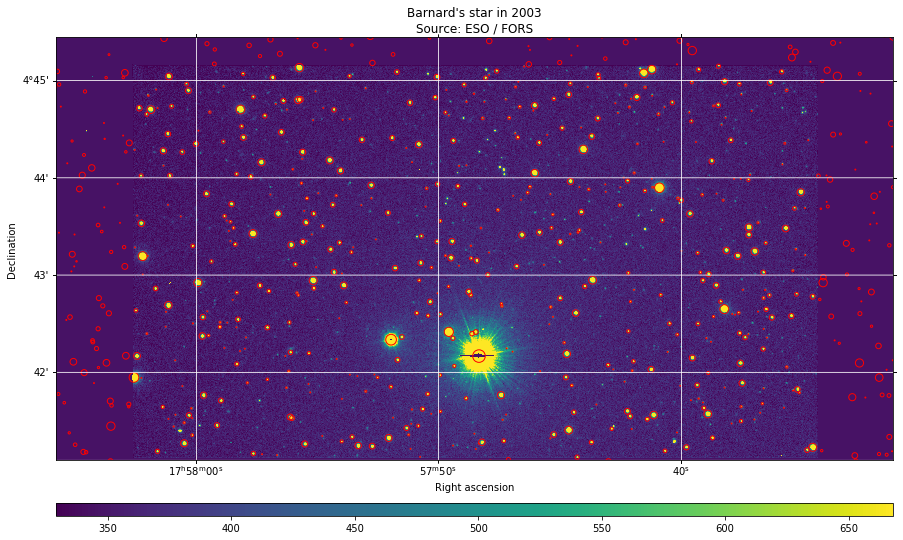

In [126]:
ax = make_image(data2003, wcs2003, 2003)
ax.scatter(gaiacoord2003.ra, gaiacoord2003.dec, s=rad,
           transform=ax.get_transform("world"), marker="o", color="r", facecolors="None");

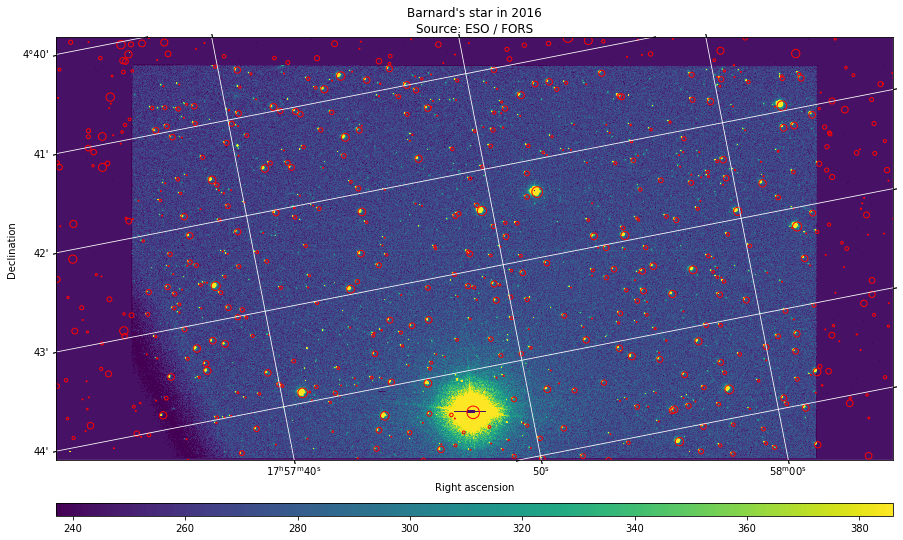

In [129]:
ax = make_image(data2016, wcs2016, 2016)
ax.scatter(gaiacoord2016.ra, gaiacoord2016.dec, s=rad,
           transform=ax.get_transform("world"), marker="o", color="r", facecolors="None");

## Extra: reproject the image

In [130]:
from reproject import reproject_interp

In [131]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    data2016_reprojected, footprint = reproject_interp(hdu2016, hdu2003[0].header)

In [132]:
data2016_reprojected[data2016_reprojected < 220] = np.nan

/anaconda/envs/school19/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


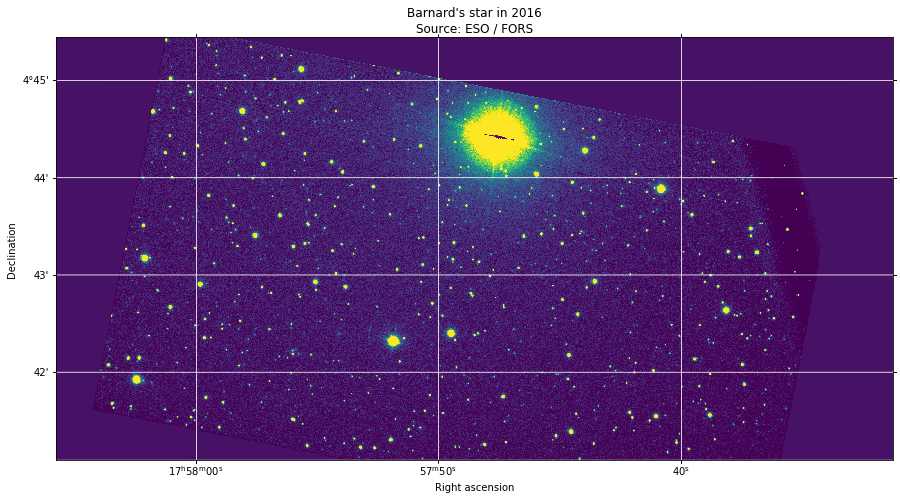

In [135]:
ax = make_image(data2016_reprojected, wcs2003, 2016, vmin=263, vmax=350, add_colorbar=False);

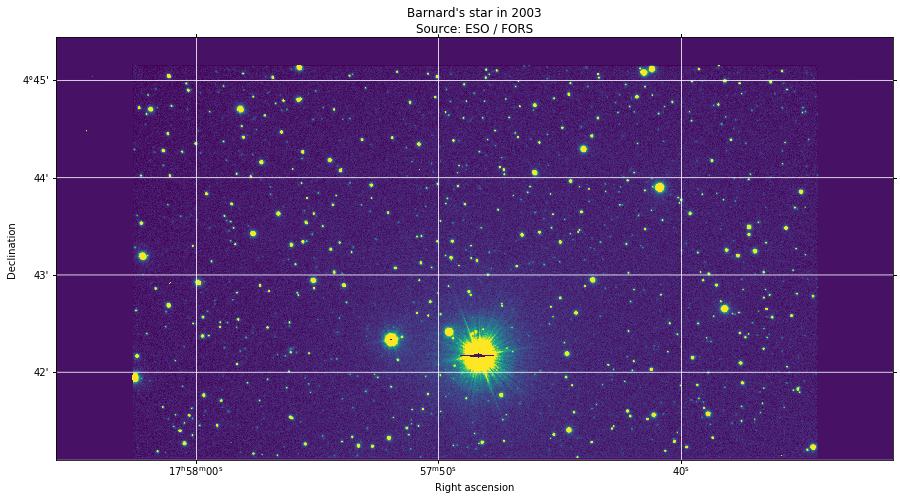

In [137]:
ax = make_image(data2003, wcs2003, 2003, add_colorbar=False);

## Extra extra

In [138]:
from ipywidgets import interactive

In [139]:
empty_data = np.ones_like(data2016_reprojected) * 0.05

In [150]:
def show_simulated_plot(time_in_year):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        gaiacoord = gaiacoord2015.apply_space_motion(new_obstime=Time(time_in_year, format="decimalyear"))
        ax = make_image(empty_data, wcs2003, "{:.1f}".format(time_in_year), vmin=0, vmax=1, add_colorbar=False)
        ax.scatter(gaiacoord.ra, gaiacoord.dec, s=rad,
                   transform=ax.get_transform("world"), marker="o", color=plt.cm.viridis(1000));

In [155]:
interactive_plot = interactive(show_simulated_plot, time_in_year=(2003., 2016.))
output = interactive_plot.children[-1]
output.layout.height = '500px'
interactive_plot

interactive(children=(FloatSlider(value=2009.5, description='time_in_year', max=2016.0, min=2003.0), Output(la…